# DS3000 Final Project: Recommender System for Spotify
## Team 11

- massud.e@northeastern.edu
- prestage.b@northeastern.edu

### Reuse Permissions
    The following may be re-used for any purposes:
    - all data included with submission
    - all images
    - this report and the notebooks which collected / cleaned the data
    - the associated [video presentation](todo:addlink)
    Please attribute any work to the authors listed above.

# Executive Summary

We built a Spotify song recommendation system by collecting public user data from Spotify's API for a target user and their friends. The recommender uses the audio features of songs provided by Spotify's API (ex. acousticness, tempo, danceability, etc) to recommend songs from the friends' playlists to the target user. The recommender [groups](#Clustering) the target user's songs and [finds similar songs](#Recommending) in the friends' songs. Our recommender system does a good job [if some assumptions hold](#Assumptions), but results may vary if the target user doesn't have preferences we can detect (i.e. a distinct group or groups), friend data is wildly different from the target user, or the amount of data given to the system is too small.


# Ethical Considerations

Because our tool recommends songs, it comes with the same bias-oriented ethical considerations that other recommender systems have. Our system pulls recommendation candidates from songs found in playlists saved by a manually specified list of users. Because the content of these playlists is not controlled, there may be strong bias towards certain artists, studios, or genres, putting artists and genres outside of the candidate pool at a disadvantage. Our system only allows users to discover new music that their friends have already discovered, so the recommendations could harm new artists, preventing them from being discovered. Our system risks popular artists getting more popular and undiscovered artists never getting discovered. **We suggest that any product derived from this work integrate randomly sampled songs from Spotify into its candidate pool to establish some equity across music producers and genres.** See [freshness, diversity, and fairness in recommendation systems](https://developers.google.com/machine-learning/recommendation/dnn/re-ranking)

# Introduction

Many people struggle to find new music that they enjoy, especially on a platform as massive as Spotify. The problem lies in "candidate generation", i.e. finding songs that are worth considering. Music listeners often turn to Spotify's auto-generated Daily Mix and Discover Weekly playlists, but many agree that the best music recommendations come from their friends. Getting music from friends manually is difficult, requiring listening to the songs to make decisions, and finding commonalities can take a long time. **The goal of this project is to automate the process of getting music recommendations from your friends. Rather than having a specific song, album, or artist explicitly recommended between friends, our project aims to recommend new songs to a user based on their preferences, using their friends' public playlists as the candidate pool.**


# Data Description

(Full details of songs data can be found in `data_analysis_and_plan_final.ipynb`, a summary of the relevant details is given here).

To collect our data, we requested public playlist data for the given user and specified friends from the [Spotify API](https://developer.spotify.com/documentation/web-api/reference/). We then aggregated this data and requested [audio feature data](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) for each track to use as our "[embedding](https://developers.google.com/machine-learning/glossary#embeddings)" in the embedding space, which will be used for recommendations.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import collections
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

In [2]:
df_eddie = pd.read_csv('eddie_song_data.csv')

df_eddie.loc[:, ['analysis_url', 'acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness']].head()

,analysis_url,acousticness,danceability,energy,liveness,loudness,speechiness
0,https://api.spotify.com/v1/audio-analysis/20Mu...,0.192,0.741,0.645,0.1630,-5.116,0.0963
1,https://api.spotify.com/v1/audio-analysis/4S7Y...,0.194,0.598,0.252,0.0992,-15.086,0.0644
2,https://api.spotify.com/v1/audio-analysis/3F1g...,0.339,0.422,0.349,0.1080,-12.424,0.3150
3,https://api.spotify.com/v1/audio-analysis/71Aa...,0.634,0.450,0.300,0.1420,-9.530,0.0477
4,https://api.spotify.com/v1/audio-analysis/4Q34...,0.231,0.647,0.667,0.1330,-5.563,0.3040


# Method

To recommend songs to users, we used a two step process.

1. We used k-Means Clustering on the user's songs to get an abstract representation of user preferences. We used the centroids as ['query embeddings'](https://developers.google.com/machine-learning/recommendation/dnn/retrieval) which we used to generate recommendations.

2. We applied k-Nearest Neighbors to find which of the friends' songs are closest to this user's centroids. For each centroid, the k-nearest songs were recommended.

In essence, we conceptualize user preference with clusters, and then recommend songs from the friends dataset based on their distance to the nearest centroid. Using friends data via a ['social graph'](https://developers.google.com/machine-learning/recommendation/dnn/scoring) is a common source for candidate generation in contemporary recommendation systems.

### Assumptions

1. The audio features of a song provide a meaningful numeric value that can be used to predict what songs the user will enjoy
    1. If audio features are not meaningful for song similarity, our embedding space isn't useful for recommendations. (Note that Spotify uses the features themselves internally for similar purposes)
1. Songs can be clustered by these attributes, and songs within a cluster are actually similar.
    1. If songs cannot be meaningfully clustered, centroids from the target user's data will be somewhat random and may not accurately represent the user's preferences.
1. There is at least some shared interest between the main user and the specified friends, and we can quantify this shared interest.
    1. If the friends' tastes are very different from the target user, recommendations may be less relevant.
1. The target user's friends have enough data for a reasonable candidate pool.
    1. If the candidate pool is too small, recommendations are less likely to be relevant as they'll have greater distances from the query vectors.

### Broad Method Outline

Our data is collected from each user's public playlists via the Spotify API, and the audio features are produced by Spotify. The audio features are used for our embedding space in which songs and queries exist as vectors.

We used [k-means clustering](https://www.geeksforgeeks.org/clustering-in-machine-learning/) to generate query embeddings from the user's songs, using the cluster centroids as the queries. 

We used [k-nearest neighbors](https://www.geeksforgeeks.org/k-nearest-neighbours/) to find the k-nearest songs to our query embeddings from the set of friends' songs. 

# Results

More details on this process can be found in our `song_rec_ML` file.
### Loading Data and PCA

In [3]:
# list of audio features that we want to use for analysis
features_list = ['acousticness', 'danceability', 'energy', 
                 'instrumentalness', 'liveness', 'loudness', 
                 'speechiness', 'tempo', 'valence']

# load target user's song data
df_eddie_full = pd.read_csv('eddie_song_data.csv')

# get audio feature data for the features we care about
df_eddie = df_eddie_full.loc[:, features_list]

# get combined song data from all users except eddie, so we can recommend songs for eddie
df_agg_full = pd.read_csv('aggragated_df.csv')

df_agg = df_agg_full.loc[:, features_list].drop_duplicates()

# apply principle component analysis to eddie's df and aggregate df
pca = PCA(whiten=True)
agg_prime = pca.fit_transform(df_agg)
eddie_prime = pca.transform(df_eddie)

## Clustering 

### Getting the centroids

In [4]:
x = eddie_prime

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(x)
y = kmeans.predict(x)

centroids = kmeans.cluster_centers_

centroids

array([[ 0.31552671, -0.4593645 ,  0.1811776 , -0.26856766, -1.11537487,
        -1.04251172,  0.97491799, -0.40438244, -0.09601713],
       [-0.93137483, -0.69856492,  0.10901999, -0.25957131, -0.35736821,
        -0.24243352,  0.57585372, -0.82139364,  2.2932634 ],
       [-0.15095606, -0.59928075, -0.10700142, -0.29138798,  0.73829749,
        -0.59409721,  0.29714476, -0.06345694, -0.00923771],
       [ 1.27727631, -0.45210176,  0.28605249, -0.32755357, -0.06789196,
        -0.32516977,  1.0622452 , -0.55508122,  2.52508574],
       [ 0.5191209 , -0.3729804 ,  0.78318777, -0.38218932, -0.24913739,
         0.93528261,  1.6151506 ,  0.34930127,  0.41287319]])

### Visualization

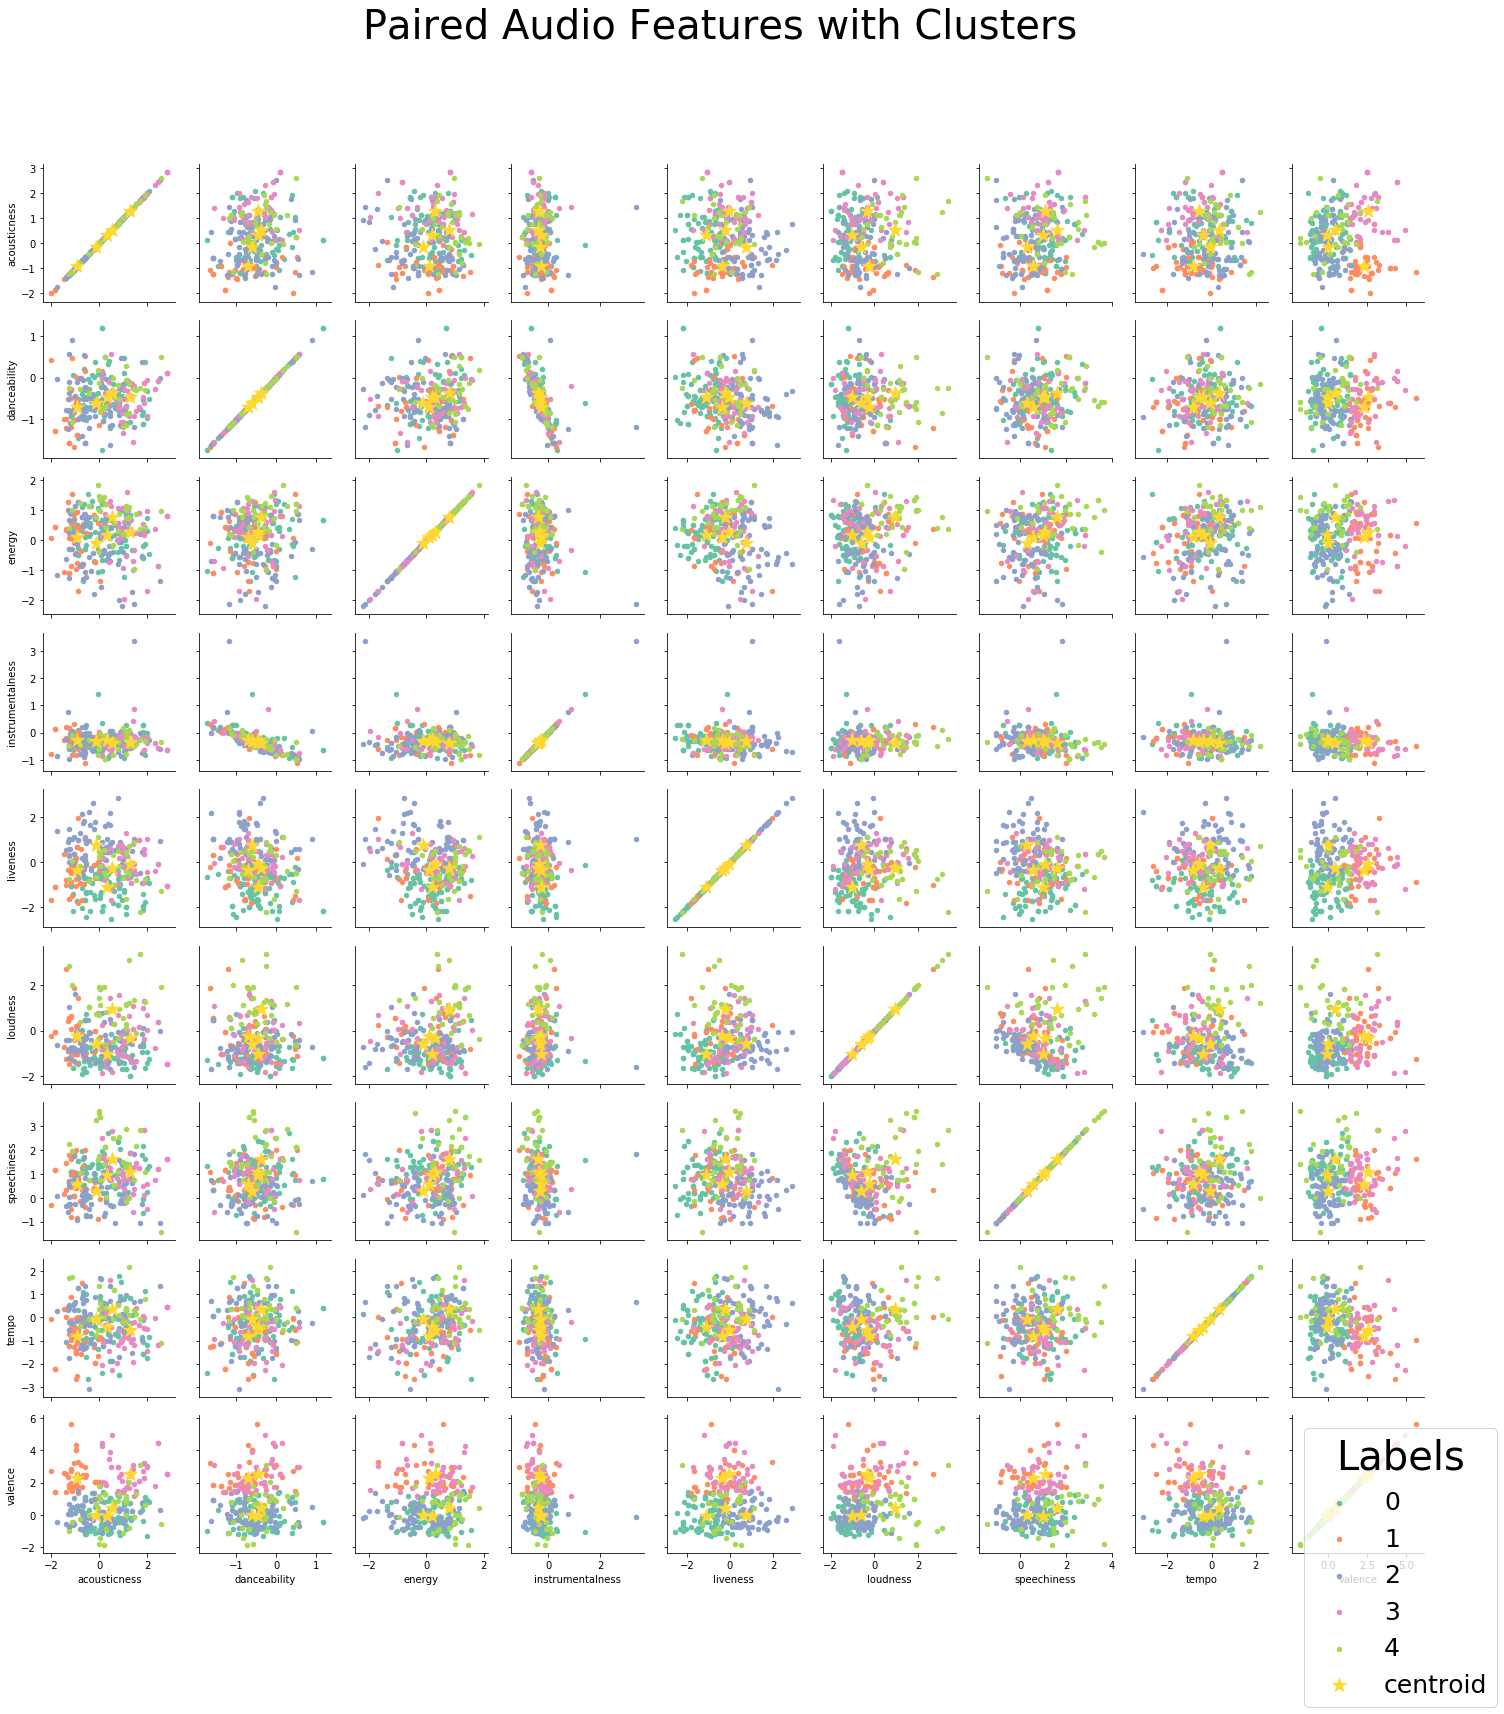

In [5]:
# add the centroids to a dataframe as rows
centroids_df = pd.DataFrame(centroids, columns=features_list)
# add a column labeling the clusters and centroids
centroids_df['cluster'] = 'centroid'

# extend eddie's dataframe to include labels
df_eddie_ext = pd.DataFrame(eddie_prime, columns=features_list)
df_eddie_ext['cluster'] = y

# combine centroids and eddie into one dataframe
eddie_centrs_df = pd.concat([df_eddie_ext, centroids_df], ignore_index=True)

# use PairGrid to display the centroids and data
centr_vis = sns.PairGrid(eddie_centrs_df, hue='cluster',
                         palette='Set2',
                         hue_kws={'s': [20, 20, 20, 20, 20, 200],
                                 'marker': ['o', 'o', 'o', 'o', 'o', '*']})

centr_vis.map(plt.scatter, linewidth=1)
plt.legend(title='Labels', fontsize='25', title_fontsize='40')
centr_vis.fig.suptitle('Paired Audio Features with Clusters', y=1.1, fontsize = 40)
centr_vis.fig.set_size_inches(20, 20)

## Recommending
The centroids we got are a coarse representation of user preference.

Now, we loop over the centroids and get k nearest for each. We treat the centroids as "query embeddings" in an embedding space of possible recommendations, and recommend the items that are closest to each query embedding.

In [6]:
# init a KD Tree that we can query to find the nearest neighbors 
kdt = KDTree(agg_prime, leaf_size=30, metric='euclidean')

rec_indices = list()

# for each centroid, get k nearest
for centroid in centroids:
    
    # reshape centroid
    centroid = centroid.reshape(-1,1)

    # query KDT to find indexes of nearest neighbors to our centroid
    nearest_list = kdt.query(centroid.T, k=10, return_distance=False)
    
    # add items that haven't already been recommended
    
    for idx in nearest_list.flatten():
        rec_indices.append(idx)

len(rec_indices)

50

Now we can see the 10 candidates closest to each query embedding. It doesn't look like much, so we'll get the corresponding songs.

In [7]:
# get the rows from df_agg corresponding to the indices we found
df_nearest = df_agg_full.iloc[rec_indices, :]

df_nearest.head()

,Unnamed: 0,Unnamed: 0.1,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
624,624,624,0.762000,https://api.spotify.com/v1/audio-analysis/3BXE...,0.530,224785.0,0.396,3BXErKHaGALZhSjwnyxMaB,0.000000,0.0,0.1240,-5.544,1.0,0.0294,129.901,4.0,https://api.spotify.com/v1/tracks/3BXErKHaGALZ...,audio_features,spotify:track:3BXErKHaGALZhSjwnyxMaB,0.6510
1269,232,232,0.131000,https://api.spotify.com/v1/audio-analysis/3nvR...,0.783,345528.0,0.693,3nvREfeASA91U3atMsVO3H,0.881000,10.0,0.0171,-7.764,0.0,0.0972,108.022,4.0,https://api.spotify.com/v1/tracks/3nvREfeASA91...,audio_features,spotify:track:3nvREfeASA91U3atMsVO3H,0.8540
1021,184,184,0.234000,https://api.spotify.com/v1/audio-analysis/2Jh3...,0.712,201920.0,0.515,2Jh3UqxnHJMyzMzku4uOtE,0.000000,10.0,0.2050,-6.004,0.0,0.0857,160.000,4.0,https://api.spotify.com/v1/tracks/2Jh3UqxnHJMy...,audio_features,spotify:track:2Jh3UqxnHJMyzMzku4uOtE,0.5630
1075,38,38,0.652000,https://api.spotify.com/v1/audio-analysis/6f6p...,0.282,345887.0,0.372,6f6pEjgfTtuRROmJ4a7Gf3,0.416000,5.0,0.0754,-9.771,1.0,0.0316,105.215,3.0,https://api.spotify.com/v1/tracks/6f6pEjgfTtuR...,audio_features,spotify:track:6f6pEjgfTtuRROmJ4a7Gf3,0.0552
839,2,2,0.000659,https://api.spotify.com/v1/audio-analysis/0HJR...,0.290,493400.0,0.827,0HJRAM7Gt9jXskuXjZeFX3,0.000003,8.0,0.3010,-3.451,1.0,0.0362,167.086,4.0,https://api.spotify.com/v1/tracks/0HJRAM7Gt9jX...,audio_features,spotify:track:0HJRAM7Gt9jXskuXjZeFX3,0.4500


### Understanding the Recommendations

In [8]:
# get list of track IDs from the dataframe
track_list = df_nearest['id'].values

# join the tracks IDs together with commas
tracks_str = ','.join(track_list)

# generate endpoint string
tracks_endpoint = f'https://api.spotify.com/v1/tracks?ids={tracks_str}'

# NOTE: tokens only last 1 hour. we need a new access token every time we want to run this
access_token = 'BQBspr8U0WrVjL-rSWf7zGQBDTfKq7hkHpA1d9FWaB1j5sCR0n5VhbdaZf9zdAkEXTFL53rEnlwU5nuFzvwi5zvoUBLu_qBLsOa17JK__NmccXiOc_rO5mkrP_GcDfUTj3zSgM8Os2QWVotsnpn-6p5C'

headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json',
    'Accept': 'application/json'
}

# request data from API
req_data = requests.get(tracks_endpoint, headers=headers)

req_json = req_data.json()

def get_recommendations(req_json):
    """parses response data from Spotify API to get artist names, track names, and URLs
    Args:
        req_json (json): json response data from Spotify API for a set of tracks
    Returns:
        df_recommendations (pd.DataFrame): dataframe of artist names, track names, and URLs 
                                           corresponding to these tracks
    """
    # init a dataframe to hold desired attributes for output
    df_recommendations = pd.DataFrame(columns=['artist name', 'track name', 'URL'])

    # for each track in our response data
    for track in req_json['tracks']:

        # init a series to hold desired attributes for output
        track_series = pd.Series()

        # get artist name
        track_series['artist name'] = track['artists'][0]['name']
        # get track name
        track_series['track name'] = track['name']
        # get track URL
        track_series['URL'] = track['external_urls']['spotify']

        # append our series to the dataframe
        df_recommendations = df_recommendations.append(track_series, ignore_index=True)
        
    return df_recommendations

get_recommendations(req_json)

,artist name,track name,URL
0,The Icarus Account,Favorite Girl,https://open.spotify.com/track/3BXErKHaGALZhSj...
1,Snarky Puppy,Bad Kids To The Back,https://open.spotify.com/track/3nvREfeASA91U3a...
2,Juice WRLD,Feeling,https://open.spotify.com/track/2Jh3UqxnHJMyzMz...
3,Radiohead,The Numbers,https://open.spotify.com/track/6f6pEjgfTtuRROm...
4,Green Day,Holiday / Boulevard of Broken Dreams,https://open.spotify.com/track/0HJRAM7Gt9jXsku...
5,Arctic Monkeys,One for the Road,https://open.spotify.com/track/7Hk6vSplBGJ6zK9...
6,Travis Scott,HIGHEST IN THE ROOM,https://open.spotify.com/track/3eekarcy7kvN4yt...
7,Lawrence,Do You Want to Do Nothing with Me? - Audiotree...,https://open.spotify.com/track/3Qeq4pMfjYwXOgJ...
8,Fat Night,Question,https://open.spotify.com/track/3lWEqatHZ2wIE2R...
9,Muse,Showbiz,https://open.spotify.com/track/2sCFFlnYg6Lk75G...


# Discussion

These results are significant for our application because we were able to derive meaningful similarity between songs and uncover some genuinely similar results and high quality, diverse recommendations. These results are not ground breaking––Spotify uses some sophisticated techniques to generate the audio features that we used for embeddings, and we applied some fairly standard machine learning techniques. 

Because there's a subjective component to our results, domain experts won't be surprised, but we managed to get similar results to Spotify's own recommendations with simple methods (albeit with a few unexpected results mixed in). Dataset bias is definitely present as it is baked into our solution itself––selecting candidates from all of Spotify isn't feasible, we specifically built a dataset that would provide good recommendations, and gave ourselves a high chance of subjective success by doing so. Our results should not be accepted at face value as performance depends heavily on which friends are used for candidate generation, a random dataset wouldn't have results like this, but the whole point is to self-select friends, so bias is a good thing here.

## Are these recommendations good?
It's difficult to quantify how good song recommendations are, so we'll give a few examples of using specific songs as the query and showing the recommendations that are made for it.


This is the endpoint for audio features of Boredom by Tyler the Creator. we found the ID by going in Spotify, clicking the 3 dots next to this song, Share -> Copy Spotify URI. 
here's the result: spotify:track:5WNYg3usc6H8N3MBEp4zVk

```python
boredom_endpoint = f'https://api.spotify.com/v1/audio-features/5WNYg3usc6H8N3MBEp4zVk'

req_boredom = requests.get(boredom_endpoint, headers=headers)

req_boredom.json()
```
Result:
{'danceability': 0.559,
 'energy': 0.578,
 'key': 8,
 'loudness': -9.54,
 'mode': 1,
 'speechiness': 0.151,
 'acousticness': 0.79,
 'instrumentalness': 0.000522,
 'liveness': 0.324,
 'valence': 0.239,
 'tempo': 79.938,
 'type': 'audio_features',
 'id': '5WNYg3usc6H8N3MBEp4zVk',
 'uri': 'spotify:track:5WNYg3usc6H8N3MBEp4zVk',
 'track_href': 'https://api.spotify.com/v1/tracks/5WNYg3usc6H8N3MBEp4zVk',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5WNYg3usc6H8N3MBEp4zVk',
 'duration_ms': 320720,
 'time_signature': 4}

```python
boredom_series = pd.Series(req_boredom.json())

# get the post-PCA values for this song from our data
df_agg_full.index[df_agg_full['id'] == '5WNYg3usc6H8N3MBEp4zVk']
# the song is at index 1189, so we can grab it from the post-PCA matrix
agg_prime[1189]

```
Result: array([-1.22901312, -0.04273093, -1.35509872,  0.4443527 , -0.13558097,
        1.09551314,  0.42465108,  1.58818226, -0.31821814])

In [9]:
boredom_pca = np.array([-1.22901312, -0.04273093, -1.35509872, 0.4443527 , -0.13558097, 1.09551314, 0.42465108, 1.58818226, -0.31821814])

# use this song as a query to our KDTree, same way we did for the centroids

nearest_boredom = kdt.query(boredom_pca.reshape(-1,1).T, k=10, return_distance=False)

nearest_boredom

array([[ 594,  647,  429, 1535,  423,  929,  280, 2103, 1638,  920]])

In [10]:
# get the rows from df_agg corresponding to the indices we found
df_nearest = df_agg_full.iloc[nearest_boredom.flatten(), :]

df_nearest.head()

,Unnamed: 0,Unnamed: 0.1,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
594,594,594,0.5850,https://api.spotify.com/v1/audio-analysis/3gri...,0.782,179310.0,0.422,3griMd2FSimhnvHWOveakD,0.000087,5.0,0.1190,-6.464,0.0,0.3110,87.091,4.0,https://api.spotify.com/v1/tracks/3griMd2FSimh...,audio_features,spotify:track:3griMd2FSimhnvHWOveakD,0.509
647,647,647,0.7150,https://api.spotify.com/v1/audio-analysis/2bbG...,0.755,189284.0,0.520,2bbG9OmvZLCsdWoRu7rj2m,0.000000,3.0,0.0956,-5.078,1.0,0.0285,95.047,4.0,https://api.spotify.com/v1/tracks/2bbG9OmvZLCs...,audio_features,spotify:track:2bbG9OmvZLCsdWoRu7rj2m,0.517
429,429,429,0.0106,https://api.spotify.com/v1/audio-analysis/1u8B...,0.645,231571.0,0.705,1u8BiP9APkwKjtVb9L1z50,0.002620,1.0,0.1100,-6.400,1.0,0.0443,98.033,4.0,https://api.spotify.com/v1/tracks/1u8BiP9APkwK...,audio_features,spotify:track:1u8BiP9APkwKjtVb9L1z50,0.647
1535,498,498,0.1730,https://api.spotify.com/v1/audio-analysis/06PN...,0.897,249293.0,0.823,06PNiDGtPIMOq9VU2ftVCk,0.000007,1.0,0.3310,-6.267,0.0,0.1890,129.056,4.0,https://api.spotify.com/v1/tracks/06PNiDGtPIMO...,audio_features,spotify:track:06PNiDGtPIMOq9VU2ftVCk,0.767
423,423,423,0.0144,https://api.spotify.com/v1/audio-analysis/6Rpu...,0.567,266813.0,0.815,6RpunyUP44SDweJPDScLSF,0.000021,8.0,0.1260,-4.915,1.0,0.1410,164.834,4.0,https://api.spotify.com/v1/tracks/6RpunyUP44SD...,audio_features,spotify:track:6RpunyUP44SDweJPDScLSF,0.325


In [11]:
# get list of track IDs from the dataframe
track_list = df_nearest['id'].values

# join the tracks IDs together with commas
tracks_str = ','.join(track_list)

# generate endpoint string
b_tracks_endpoint = f'https://api.spotify.com/v1/tracks?ids={tracks_str}'

b_req_data = requests.get(b_tracks_endpoint, headers=headers)

get_recommendations(b_req_data.json())

,artist name,track name,URL
0,Hablot Brown,She Said,https://open.spotify.com/track/3griMd2FSimhnvH...
1,Olivia Willhite,Runaway Man,https://open.spotify.com/track/2bbG9OmvZLCsdWo...
2,Cory Henry,Happy Days,https://open.spotify.com/track/1u8BiP9APkwKjtV...
3,Jacob Collier,In My Bones (feat. Kimbra & Tank and The Bangas),https://open.spotify.com/track/06PNiDGtPIMOq9V...
4,Anderson .Paak,Come Home (feat. André 3000),https://open.spotify.com/track/6RpunyUP44SDweJ...
5,Muse,Starlight,https://open.spotify.com/track/3skn2lauGk7Dx6b...
6,Anderson .Paak,King James,https://open.spotify.com/track/5ri4b7YQp2PWn8t...
7,NxWorries,Suede,https://open.spotify.com/track/4F07ku5lMBIoybF...
8,Giorgio Conte,"Gnè, Gnè",https://open.spotify.com/track/0uk5fPe0jKtNG19...
9,Charlie Brown Jr.,Ela Vai Voltar (Todos Os Defeitos De Uma Mulhe...,https://open.spotify.com/track/70dJEanFPdYuWZu...


### Takeaway
In conclusion, our song recommendations are subjectively appropriate to a reasonable degree. These recommendations could definitely be used within circles of friends to generate song recommendations, and these actions are justified because they're low-impact, low-reward actions. Generating a playlist of good song recommendations helps people discover new music that they enjoy, which is a good thing, and it increases revenue for music artists. Before making this accessible, it would be wise to integrate some randomly sampled candidates from Spotify so that artists outside of those who are well known can be recognized (which will also increase the diversity and fairness of our results).